## Simple Harmonic Oscillator Physics Informed Neural Network
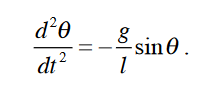

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd

## Generate Training and Testing Data

## Create Neural Network

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()

        self.activation = nn.Tanh() #activation function
        self.loss_function = nn.MSELoss(reduction ='mean') #loss function

        #self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]), add parameter for class if so

        #  MANUAL LAYERS, 4 layers with 2 hidden
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.xavier_normal_(self.fc4.weight)

        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)


    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        
        return x



NameError: name 'nn' is not defined